# Creating custom solvers

This is a showcase how the sample steppers in `exponax.sample_stepper` are implemented.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
import exponax as ex
from exponax import BaseStepper
from exponax.nonlin_fun import BaseNonlinearFun, ConvectionNonlinearFun

### A viscous Korteveg-de Vries equation

By default the KdV stepper is non-diffusive. Let's create a custom stepper that has an additional diffusion term.

In [11]:
from jaxtyping import Array, Complex


class KdV_diffusive(BaseStepper):
    # Declare your constitutive parameters here
    convection_scale: float
    diffusivity: float  # This is the term not present in the pre-made KdV stepper
    dispersivity: float

    # This is necessary to correctly instantiate the nonlinear function
    dealiasing_fraction: float

    def __init__(
        self,
        # The first four positional arguments are always the same, i.e.,
        # dimensions, domain size, number of degrees of freedom and time step
        # size
        num_spatial_dims: int,
        domain_extent: float,
        num_points: int,
        dt: float,
        *,
        # The first range of keyword arguments should be constitutive
        # parameters, make sure to set reasonable defaults
        convection_scale: float = -6,
        diffusivity: float = 0.01,
        dispersivity: float = 1.0,
        # The second range of keyword arguments should be numerical parameters;
        # oftentimes it is fine to use the same as in other methods
        order: int = 2,
        dealiasing_fraction: float = 2 / 3,
        num_circle_points: int = 16,
        circle_radius: float = 1.0,
    ):
        """
        Add a docstring here
        """

        # First, save the constitutive parameters
        self.convection_scale = convection_scale
        self.diffusivity = diffusivity
        self.dispersivity = dispersivity

        # Then save the dealiasing fraction
        self.dealiasing_fraction = dealiasing_fraction

        # Then, call the parent constructor
        super().__init__(
            num_spatial_dims,
            domain_extent,
            num_points,
            dt,
            # The KdV equation uses a convection nonlinearity for which the
            # number of channels grows with the spatial dimension
            num_channels=num_spatial_dims,
            # Pass the numerical parameters to the parent constructor
            order=order,
            num_circle_points=num_circle_points,
            circle_radius=circle_radius,
        )

    # We have to implement two methods `_build_linear_operator` and `_build_nonlinear_fun`

    def _build_linear_operator(self, derivative_operator: Array) -> Array:
        diffusion_part = self.diffusivity * derivative_operator**2
        # We need a minus here because this term of the equation is moved to the
        # right hand side
        dispersion_part = -self.dispersivity * derivative_operator**3

        linear_operator = diffusion_part + dispersion_part
        return linear_operator

    def _build_nonlinear_fun(self, derivative_operator: Array) -> BaseNonlinearFun:
        # The nonlinear given by convection, i.e., $c * (u^2)_x$ is so common
        # among (semi-linear/) nonlinear PDEs that there is shared nonlinear
        # function.
        nonlinear_fun = ConvectionNonlinearFun(
            self.num_spatial_dims,
            self.num_points,
            derivative_operator=derivative_operator,
            dealiasing_fraction=self.dealiasing_fraction,
            scale=self.convection_scale,
        )
        return nonlinear_fun

Text(0.5, 1.0, 'Diffusive KdV')

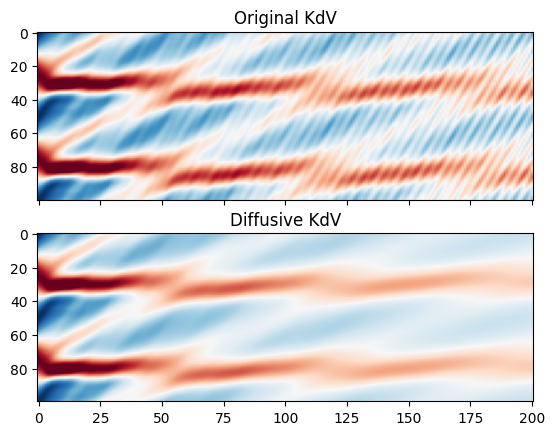

In [13]:
DOMAIN_EXTENT = 20.0
NUM_POINTS = 100
DT = 0.05

original_kdv_stepper = ex.stepper.KortewegDeVries(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    dispersivity=1.0,
    convection_scale=-6,
)
diffusive_kdv_stepper = KdV_diffusive(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    diffusivity=0.1,
    dispersivity=1.0,
    convection_scale=-6,
)

mesh = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
u_0 = jnp.cos(4 * jnp.pi * mesh / DOMAIN_EXTENT)

original_kdv_trj = ex.rollout(original_kdv_stepper, 200, include_init=True)(u_0)
diffusive_kdv_trj = ex.rollout(diffusive_kdv_stepper, 200, include_init=True)(u_0)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].imshow(original_kdv_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
ax[0].set_title("Original KdV")
ax[1].imshow(diffusive_kdv_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
ax[1].set_title("Diffusive KdV")

### Heat Equation with nonlinear source term

$$ \partial_t u = \nu \partial_x^2 u + \frac{1}{1 + u^2} $$

For these highly nonlinear equations, it is hard to say how strong the
dealiasing should be. Having a fraction of $1/2$ is a good first guess.

In [17]:
class NonlinearSourceFun(BaseNonlinearFun):
    # The constructor of a nonlinear function should take as positional
    # arguments the number of spatial dimensions and the number of points. The
    # derivative operator should be a keyword argument. Here, we do not need; so
    # let's not include it.
    def __init__(
        self,
        num_spatial_dims: int,
        num_points: int,
        *,
        dealiasing_fraction: float = 1 / 2,
    ):
        super().__init__(
            num_spatial_dims,
            num_points,
            dealiasing_fraction=dealiasing_fraction,
        )

    def __call__(self, u_hat: Array) -> Array:
        # When inheriting from BaseNonlinearFun, we can use the the class
        # methods `fft` and `ifft` to perform the correct (real-valued) Fourier
        # transforms. Make sure to dealias before evaluating nonlinear terms.
        u = self.ifft(self.dealias(u_hat))
        u_nonlin = 1 / (1 + u**2)
        u_nonlin_hat = self.fft(u_nonlin)
        return u_nonlin_hat


class Diffusion_nonlinear_source(BaseStepper):
    diffusivity: float

    dealiasing_fraction: float

    def __init__(
        self,
        num_spatial_dims: int,
        domain_extent: float,
        num_points: int,
        dt: float,
        *,
        diffusivity: float = 0.01,
        # The below numerics parameters normally would not be necessary for the
        # linear heat PDE, because any linear PDE on periodic boundaries can be
        # exactly integrated in time with the Fourier spectral method (given it
        # is band-limited). However, here we added a nonlinear source term.
        order: int = 2,
        dealiasing_fraction: float = 1 / 2,  # Using a stronger dealiasing
        num_circle_points: int = 16,
        circle_radius: float = 1.0,
    ):
        self.diffusivity = diffusivity
        self.dealiasing_fraction = dealiasing_fraction
        super().__init__(
            num_spatial_dims,
            domain_extent,
            num_points,
            dt,
            # The heat equation's channel will always be 1, no matter the
            # spatial dimension
            num_channels=1,
            order=order,
            num_circle_points=num_circle_points,
            circle_radius=circle_radius,
        )

    def _build_linear_operator(self, derivative_operator: Array) -> Array:
        return self.diffusivity * derivative_operator**2

    def _build_nonlinear_fun(self, derivative_operator: Array) -> BaseNonlinearFun:
        return NonlinearSourceFun(
            self.num_spatial_dims,
            self.num_points,
            dealiasing_fraction=self.dealiasing_fraction,
        )

Text(0.5, 1.0, 'Nonlinear Diffusion')

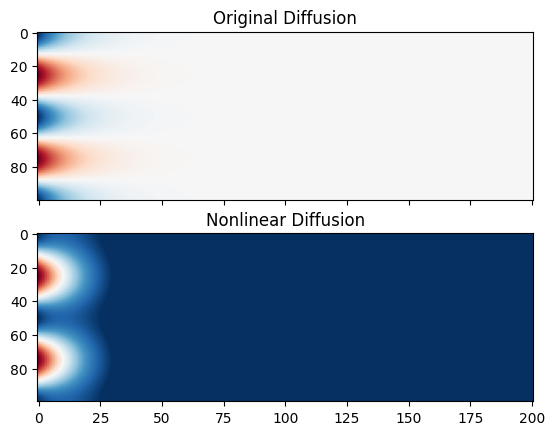

In [19]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.05
NU = 0.01

original_diffusion_stepper = ex.stepper.Diffusion(
    1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU
)
nonlinear_diffusion_stepper = Diffusion_nonlinear_source(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    diffusivity=NU,
)

mesh = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
u_0 = jnp.cos(4 * jnp.pi * mesh / DOMAIN_EXTENT)

original_diffusion_trj = ex.rollout(original_diffusion_stepper, 200, include_init=True)(
    u_0
)
nonlinear_diffusion_trj = ex.rollout(
    nonlinear_diffusion_stepper, 200, include_init=True
)(u_0)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].imshow(
    original_diffusion_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1
)
ax[0].set_title("Original Diffusion")
ax[1].imshow(
    nonlinear_diffusion_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1
)
ax[1].set_title("Nonlinear Diffusion")